#  Прогнозирование заказов такси

## Подготовка

In [229]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

In [230]:
data = pd.read_csv('/datasets/taxi.csv')

In [231]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [233]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков нет. Подозрительных значений не обнаружено. Перезапишем датасет с индексом в виде дат

In [234]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [235]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [236]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Данные готовы можно приступать к анлизу.

## Анализ

<AxesSubplot:xlabel='datetime'>

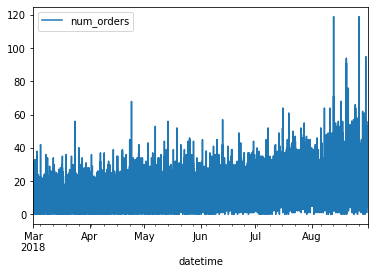

In [237]:
# построим график и посмотрим как распределены данные
data.plot()

<AxesSubplot:xlabel='datetime'>

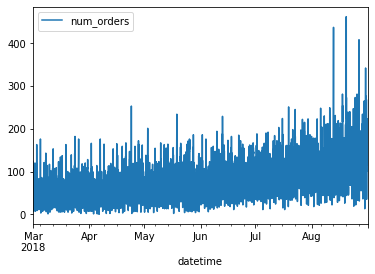

In [238]:
# на таком графике ничего не видно, проведем ресемплинг с интервалом в один час, как того требует задача прогнозирования
data = data.resample('1H').sum()
data.plot()

<AxesSubplot:xlabel='datetime'>

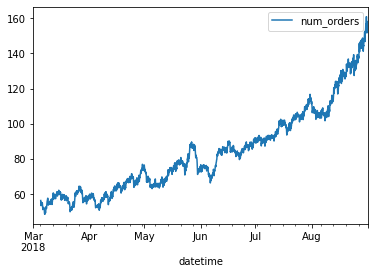

In [239]:
# аналогично данные непрезентабельны посмотрим на скользящую среднюю

data.rolling(100).mean().plot()

На данном графике видно, что с весны по конец лета наблюдается стабильные рост заказов, с небольшими падениями. Посмотрим на тренд и сезонность этих данных.

Text(0.5, 1.0, 'Seasonality')

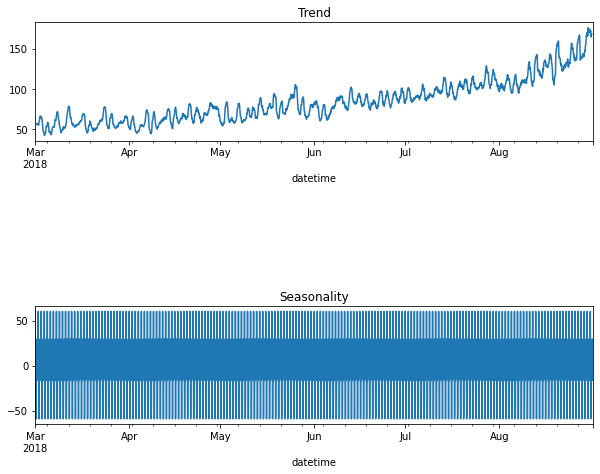

In [240]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 10))
plt.subplot(411)
decomposed.trend.plot()
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal.plot()
plt.title('Seasonality')


Тренд имеет постепенное увеличение, как было ранее выявлено, сезонность же плохо видно, поэтому возьмем период в несколько дней одного  случайного месяца

<AxesSubplot:xlabel='datetime'>

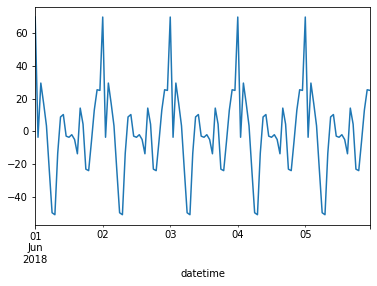

In [241]:
decomposed = seasonal_decompose(data['2018-06-01':'2018-06-05'])
decomposed.seasonal.plot()

Видно, что пик идет к концу дня и снижается в начале следующего, что логично людям  надо спать, а не ездить в такси.

<AxesSubplot:xlabel='datetime'>

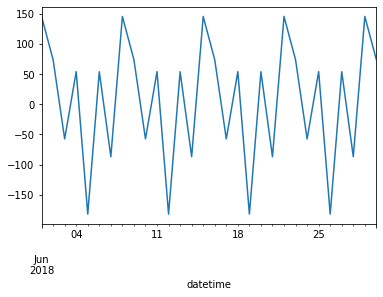

In [242]:
data_week = data.resample('1D').sum()
decomposed = seasonal_decompose(data_week['2018-06-01':'2018-06-30'])
decomposed.seasonal.plot()

Здесь видно сильное падение по вторникам, что связанно скорее всего с расписанием рейсов, возможно  в этот день не очень много пассажирских. Также видим большой спрос на такси по пятницам., видимо много рейсов на выходные.

## Обучение

In [243]:
#Подготовим данные  обучения и создадим колонки с информацией для датасета с помощью функции.

def features(data, max_lag, rolling_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()


features(data, 2, 24)

In [244]:
# убирем строки с пустыми значениями
data = data.dropna()

In [245]:
# разделим выборку, не перемешивая данные
features = data.drop('num_orders', axis=1)
target = data['num_orders']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.1, shuffle=False)

In [246]:
# обучим линейную регрессию
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

LinearRegression()

In [247]:
# обучим случайные лес
forest_model = RandomForestRegressor(max_depth=6, n_estimators=60, random_state=100)
forest_model.fit(features_train, target_train)

RandomForestRegressor(max_depth=6, n_estimators=60, random_state=100)

In [248]:
# обучим модель градиентного бустинга

boost_model = CatBoostRegressor(iterations=1000, 
                                loss_function='RMSE', 
                                random_state=100,
                                max_depth=6                    
                               )

boost_model.fit(features_train, target_train, verbose=20)

Learning rate set to 0.050898
0:	learn: 37.7314462	total: 1.88ms	remaining: 1.88s
20:	learn: 28.3789562	total: 38.4ms	remaining: 1.79s
40:	learn: 25.4814200	total: 70.1ms	remaining: 1.64s
60:	learn: 24.3719923	total: 103ms	remaining: 1.59s
80:	learn: 23.6773200	total: 135ms	remaining: 1.54s
100:	learn: 23.2858151	total: 167ms	remaining: 1.49s
120:	learn: 22.7802208	total: 202ms	remaining: 1.46s
140:	learn: 22.2556169	total: 232ms	remaining: 1.42s
160:	learn: 21.8546263	total: 267ms	remaining: 1.39s
180:	learn: 21.5362284	total: 299ms	remaining: 1.35s
200:	learn: 21.2376444	total: 328ms	remaining: 1.3s
220:	learn: 20.9393730	total: 363ms	remaining: 1.28s
240:	learn: 20.6643153	total: 394ms	remaining: 1.24s
260:	learn: 20.2979684	total: 425ms	remaining: 1.2s
280:	learn: 20.0097173	total: 459ms	remaining: 1.17s
300:	learn: 19.7288846	total: 490ms	remaining: 1.14s
320:	learn: 19.4852844	total: 524ms	remaining: 1.11s
340:	learn: 19.2255339	total: 556ms	remaining: 1.07s
360:	learn: 19.061517

## Тестирование

In [249]:
#проверяем метрику на тестовой выборке
predict_linear = linear_model.predict(features_valid)
print('RSME:', mean_squared_error(target_valid,predict_linear)**0.5)

RSME: 53.65446349996738


Ошибка линейной регресси составила почти 54 заказов. Проверим другие модели

In [250]:
predict_forest = forest_model.predict(features_valid)
print('RSME:', mean_squared_error(target_valid,predict_forest)**0.5)

RSME: 53.57560516600011


Для леса данная задачка оказалась сложнее, он ошибается тоже в целом на 54 заказов.

In [251]:
predict_boost = boost_model.predict(features_valid)
print('RSME:', mean_squared_error(target_valid,predict_boost)**0.5)

RSME: 45.41052859841265


У градиентного бустинга результат получше, хотя в среднем ошибка составила всего лишь чуть более 45 заказов.

Как выяснелось, заказы на такси имеют тренд к росту с весны по конец лета, хотя данное утверждение стоит проверить на более долгом временном ряде, тут к сожалению данных недостаточно. Также есть каждодневная сезонность, которая заключается в том, что в первой половине суток есть спади резкий рост во второй половине дня. И сезонность по дням недели, где спады приходятся на вторники, а подьемы на пятницы. Линейная регресси и случайные лес, дали результат примерно на одном уровне, но больше чем необходимые 48. Лучший результат по метрике RSME дала модель градиентного бустинга, которая смогла справится с поставленной задачей(45,4). 

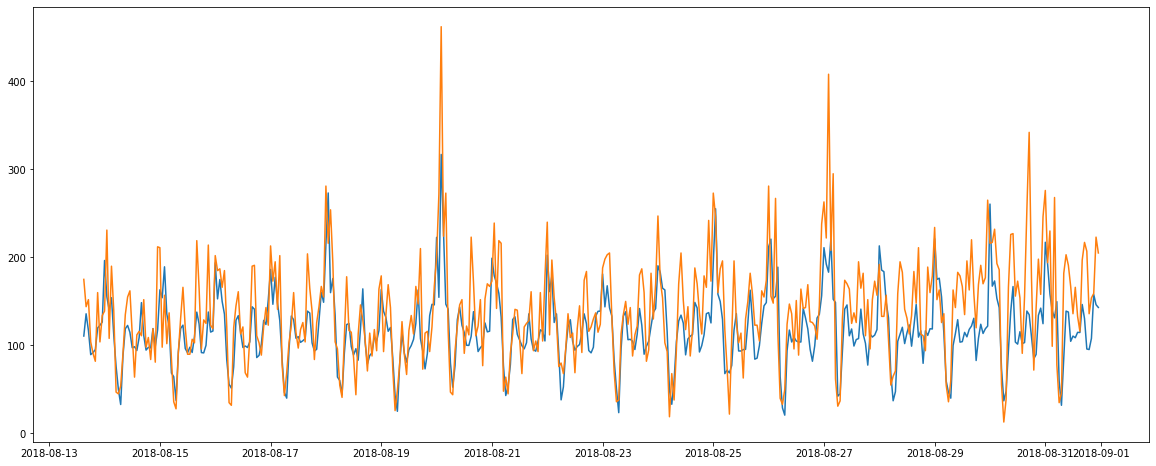

In [260]:
#дополнительно посмотрим где больше всего ошиблась модель
predict_boost = pd.Series(predict_boost, index=target_valid.index)

plt.figure(figsize=(20, 8))
plt.plot(predict_boost)
plt.plot(target_valid)

Сильнее всего модель начала ошибаться ближе к концу отрезка, подозреваю, что чем дальше в будущие тем модели сложнее делать прогнозирование.